# Feature variation by substitution ($\nu_{\phi}$)

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
N_COMPONENTS = 3
BIN_COUNT = 4

Imports and database setup.

In [2]:
from itertools import product

import pandas as pd
import seaborn as sb
from scipy import stats
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope
engine = init_db()

## 2 Variation of features upon substitution

First build our data.

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all, 1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, destination = substitution.features(feature)
            source_rel, destination_rel = \
                substitution.features(feature, sentence_relative='median')
            data.append({
                'cluster_id': substitution.source.cluster.sid,
                'destination_id': substitution.destination.sid,
                'occurrence': substitution.occurrence,
                'position': substitution.position,
                'source_id': substitution.source.sid,
                'feature': feature,
                'source': source,
                'source_rel': source_rel,
                'destination': destination,
                'destination_rel': destination_rel,
                'h0': substitution.feature_average(feature),
                'h0_rel': substitution.feature_average(
                        feature, sentence_relative='median'),
                'h0n': substitution.feature_average(
                        feature, source_synonyms=True),
                'h0n_rel': substitution.feature_average(
                        feature, source_synonyms=True,
                        sentence_relative='median')})

original_variations = pd.DataFrame(data)
del data

Got 6318 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=1)


100% (6318 of 6318) |######################| Elapsed Time: 0:02:10 Time: 0:02:10


Compute cluster averages (so as not to overestimate confidence intervals) and crop data so that we have acceptable CIs.

In [4]:
variations = original_variations\
    .groupby(['destination_id', 'occurrence', 'position', 'feature'],
             as_index=False).mean()\
    .groupby(['cluster_id', 'feature'], as_index=False)\
    ['source', 'source_rel', 'destination', 'destination_rel', 'feature',
     'h0', 'h0_rel', 'h0n', 'h0n_rel'].mean()
variations['variation'] = variations['destination'] - variations['source']

# HARDCODED: drop values where source AoA is above 15.
# This crops the graphs to acceptable CIs.
variations.loc[(variations.feature == 'aoa') & (variations.source > 15),
               ['source', 'source_rel', 'destination', 'destination_rel',
                'h0', 'h0_rel', 'h0n', 'h0n_rel']] = np.nan

Prepare feature ordering.

In [5]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

### What we plot about features

For a feature $\phi$, plot:

* $\nu_{\phi}$, the average feature of an appearing word upon substitution, as a function of the feature of the disappearing word:
$$\nu_{\phi}(f) = \left< \phi(w') \right>_{\{w \rightarrow w' | \phi(w) = f \}}$$
* $\nu_{\phi}^0$ (which is the average feature value), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi}^{00}$ (which is the average feature value for synonyms of the source word), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

We also plot these values relative to the sentence average, i.e.:

* $\nu_{\phi, r}$, the average sentence-relative feature of an appearing word upon substitution as a function of the sentence-relative feature of the disappearing word, i.e. $\phi($destination$) - \phi($destination sentence$)$ as a function of $\phi($source$) - \phi($source sentence$)$
* $\nu_{\phi, r}^0$ (which is the average feature value minus the sentence average), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi, r}^{00}$ (which is the average feature value for synonyms of the source word minus the sentence average), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

Those values are plotted with fixed-width bins, then quantile bins, with absolute feature values, then with relative-to-sentence features.

In [6]:
def print_significance(name, bins, h0, h0n, values):
    bin_count = bins.max() + 1
    print()
    print('-' * len(name))
    print(name)
    print('-' * len(name))
    header = ('Bin  |   '
              + ' |   '.join(map(str, range(1, bin_count + 1)))
              + ' |')
    print(header)
    print('-' * len(header))
    
    for null_name, nulls in [('H_0 ', h0), ('H_00', h0n)]:
        bin_values = np.zeros(bin_count)
        bin_nulls = np.zeros(bin_count)
        cis = np.zeros((bin_count, 3))

        for i in range(bin_count):
            indices = bins == i
            n = (indices).sum()
            s = values[indices].std(ddof=1)

            bin_values[i] = values[indices].mean()
            bin_nulls[i] = nulls[indices].mean()
            for j, alpha in enumerate([.05, .01, .001]):
                cis[i, j] = (stats.t.ppf(1 - alpha/2, n - 1)
                             * values[indices].std(ddof=1)
                             / np.sqrt(n - 1))

        print(null_name + ' |', end='')
        differences = ((bin_values[:,np.newaxis]
                        < bin_nulls[:,np.newaxis] - cis)
                       | (bin_values[:,np.newaxis]
                          > bin_nulls[:,np.newaxis] + cis))
        for i in range(bin_count):
            if differences[i].any():
                n_stars = np.where(differences[i])[0].max()
                bin_stars = '*' * (1 + n_stars) + ' ' * (2 - n_stars)
            else:
                bin_stars = 'ns.'
            print(' ' + bin_stars + ' |', end='')
        print()

In [7]:
def plot_variation(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    feature_field = kwargs.get('feature_field', 'feature')
    rel = '_rel' if relative else ''
    x = data['source' + rel]
    y = data['destination' + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_bins, bins = cut(x, bin_count, labels=False,
                               retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        h0s[i] = h0[indices].mean()
        h0ns[i] = h0n[indices].mean()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n - 1))
    
    # Plot.
    nuphi = r'\nu_{\phi' + (',r' if relative else '') + '}'
    plt.plot(middles, values, '-', lw=2, color=color,
             label='${}$'.format(nuphi))
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(nuphi))
    plt.plot(middles, h0ns, linestyle='-.',
             color=sb.desaturate(color, 0.2),
             label='${}^{{00}}$'.format(nuphi))
    plt.plot(middles, middles, linestyle='dotted',
             color=sb.desaturate(color, 0.2),
             label='$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

    # Test for statistical significance
    print_significance(str(data.iloc[0][feature_field]),
                       x_bins, h0, h0n, y)

In [8]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel,
              feature_field='feature', plot_kws={}):
    g = sb.FacetGrid(data=data[data[feature_field]
                               .map(lambda f: f in features)],
                     sharex=False, sharey=False,
                     col=feature_field, hue=feature_field,
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

In [9]:
def plot_bias(ax, data, color, ci=True, relative=False, quantiles=False):
    feature = data.iloc[0].feature
    rel = '_rel' if relative else ''
    x = data['source' + rel]
    y = data['destination' + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_bins, bins = cut(x, bin_count, labels=False,
                               retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        h0s[i] = h0[indices].mean()
        h0ns[i] = h0n[indices].mean()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n - 1))
    
    # Plot.
    scale = abs(h0s.mean())
    ax.plot(np.linspace(0, 1, bin_count),
            (values - h0ns) / scale, '-', lw=2, color=color,
            label=Substitution._transformed_feature(feature).__doc__)
    if ci:
        ax.fill_between(np.linspace(0, 1, bin_count),
                        (values - h0ns - cis) / scale,
                        (values - h0ns + cis) / scale,
                        color=sb.desaturate(color, 0.2), alpha=0.2)        

In [10]:
def plot_overlay(data, features, filename, palette_name,
                 plot_function, title, xlabel, ylabel, plot_kws={}):
    palette = sb.color_palette(palette_name, len(features))
    fig, ax = plt.subplots(figsize=(12, 6))
    for j, feature in enumerate(features):
        plot_function(ax, data[data.feature == feature].dropna(),
                      color=palette[j], **plot_kws)
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if SAVE_FIGURES:
        fig.savefig(settings.FIGURE.format(filename),
                    bbox_inches='tight', dpi=300)
    return ax

### 2.1 Global feature values

#### 2.1.1 Bins of distribution of appeared global feature values

For each feature $\phi$, we plot the variation upon substitution as explained above


-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | *** |
H_00 | *** | *** | *** | ns. |

--------------
phonemes_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *   | **  |
H_00 | *** | ns. | ns. | ns. |

---------------
syllables_count
---------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | ns. | *** | **  |
H_00 | *** | ns. | *   | *   |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *   |
H_00 | *** | *** | *** | ns. |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | **  | *   |
H_00 | ns. | *** | *** | *** |

-----------
betweenness
-----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | ns. | *** | *** |
H_00 | ns. | ns. | **  | *** |

----------
clustering

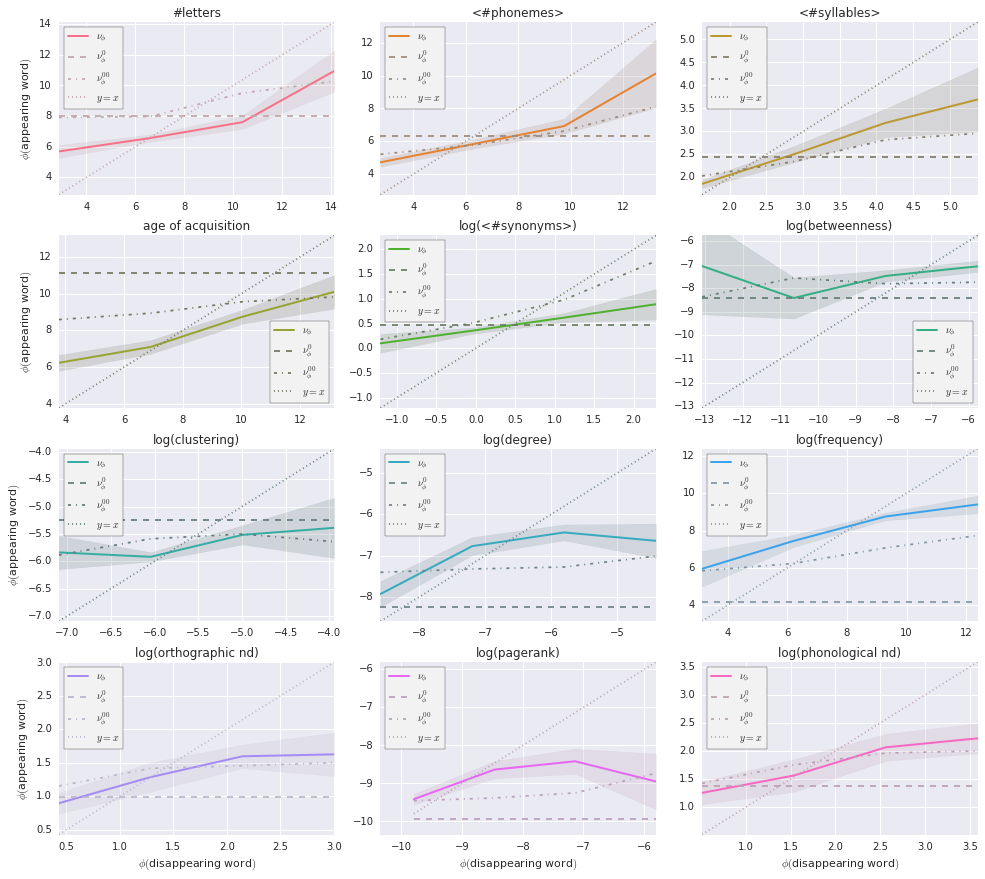

In [11]:
plot_grid(variations, ordered_features,
          'all-variations-fixedbins_global', plot_variation,
          r'$\phi($disappearing word$)$', r'$\phi($appearing word$)$')

Then plot $\nu_{\phi} - \nu_{\phi}^{00}$ for each feature (i.e. the measured bias) to see how they compare

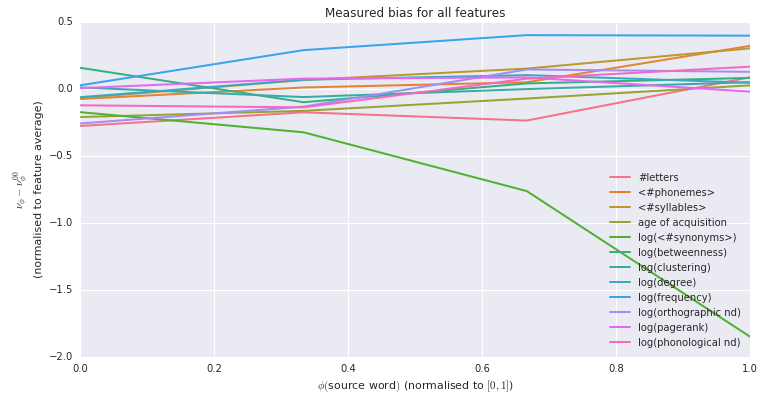

In [12]:
plot_overlay(variations, ordered_features,
             'all-variations_bias-fixedbins_global',
             'husl', plot_bias, 'Measured bias for all features',
             r'$\phi($source word$)$ (normalised to $[0, 1]$)',
             r'$\nu_{\phi} - \nu_{\phi}^{00}$'
                 '\n(normalised to feature average)',
             plot_kws={'ci': False});


---------
frequency
---------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | ns. | *** | *** | *** |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *   |
H_00 | *** | *** | *** | ns. |

----------
clustering
----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | **  | ns. |
H_00 | ns. | *** | ns. | ns. |

-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | *** |
H_00 | *** | *** | *** | ns. |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | **  | *   |
H_00 | ns. | *** | *** | *** |

--------------------
orthographic_density
--------------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | **  | *** | *** |
H_00 | **  | ns. | ns. | ns. |


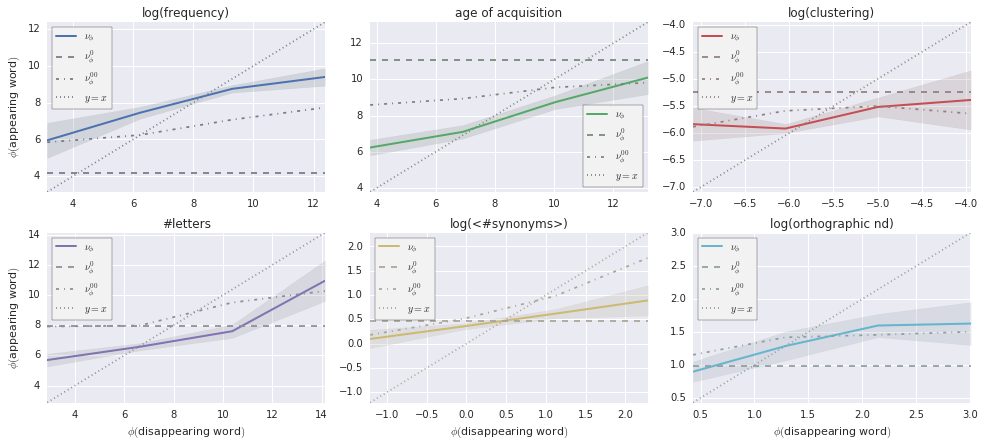

In [13]:
plot_grid(variations, PAPER_FEATURES,
          'paper-variations-fixedbins_global', plot_variation,
          r'$\phi($disappearing word$)$', r'$\phi($appearing word$)$')

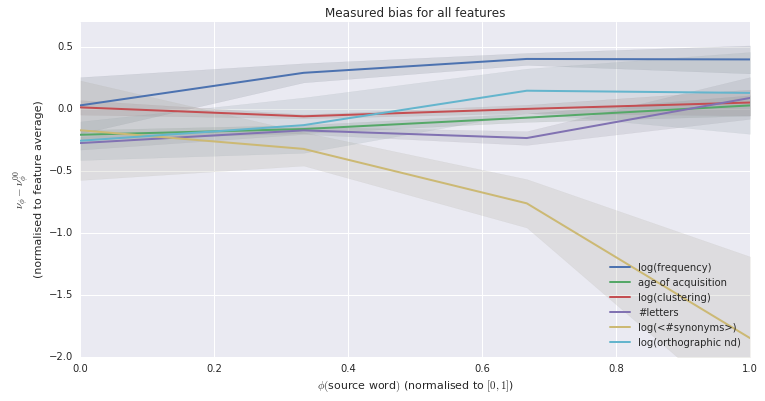

In [14]:
plot_overlay(variations, PAPER_FEATURES,
             'paper-variations_bias-fixedbins_global',
             'deep', plot_bias, 'Measured bias for all features',
             r'$\phi($source word$)$ (normalised to $[0, 1]$)',
             r'$\nu_{\phi} - \nu_{\phi}^{00}$'
                 '\n(normalised to feature average)')\
    .set_ylim(-2, .7);

#### 2.1.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | *** |

--------------
phonemes_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | *** |
H_00 | *** | ns. | ns. | *   |

---------------
syllables_count
---------------
Bin  |   1 |   2 |   3 |
------------------------
H_0  | *** | *** | *** |
H_00 | **  | **  | *** |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *   |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | **  | ns. | *** |
H_00 | ns. | *** | *** | *** |

-----------
betweenness
-----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | ns. | *   | *** | *** |

----------
clustering
----------
Bin  |   1 |

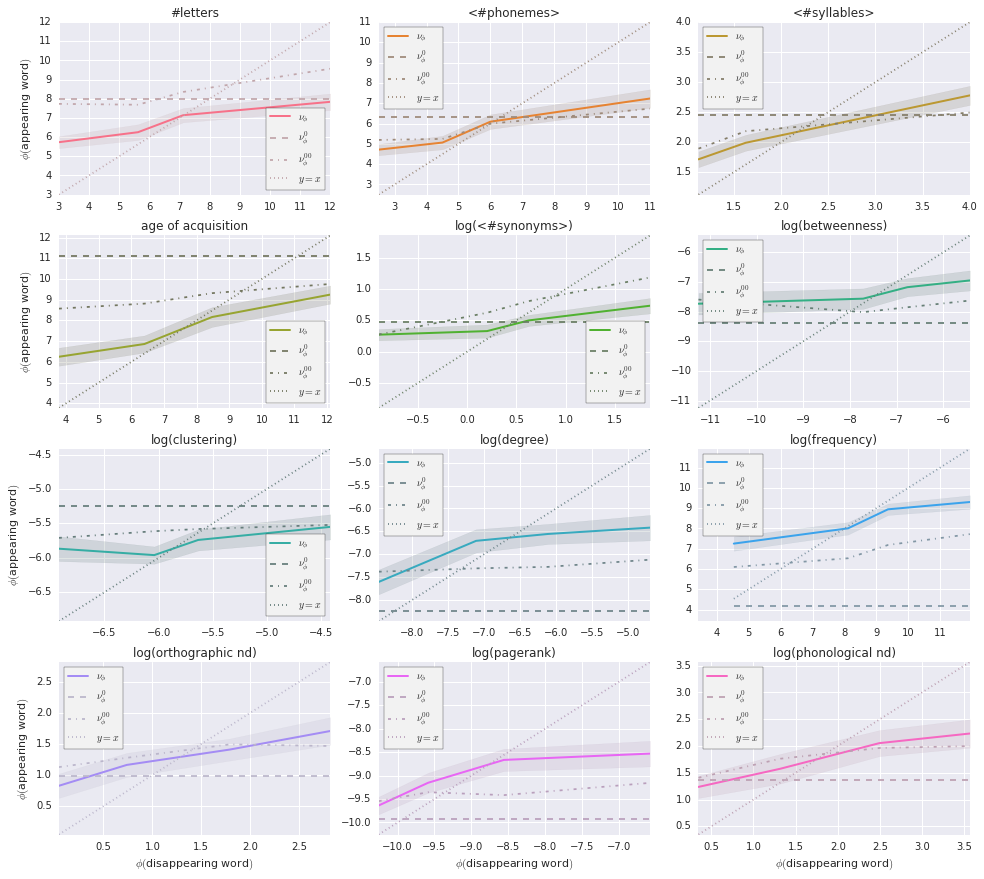

In [15]:
plot_grid(variations, ordered_features,
          'all-variations-quantilebins_global', plot_variation,
          r'$\phi($disappearing word$)$', r'$\phi($appearing word$)$',
          plot_kws={'quantiles': True})

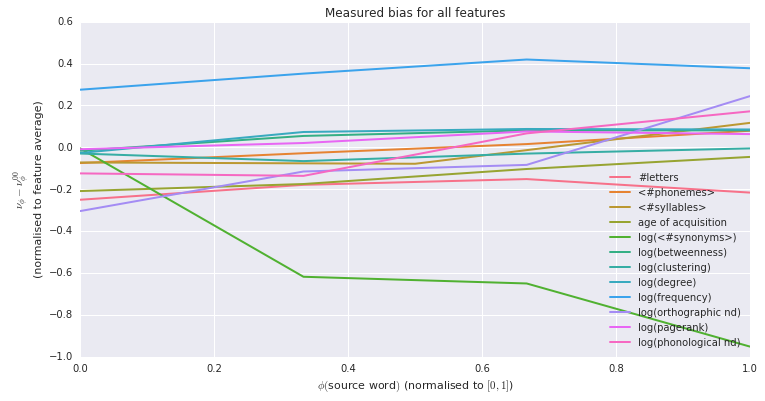

In [16]:
plot_overlay(variations, ordered_features,
             'all-variations_bias-quantilebins_global',
             'husl', plot_bias, 'Measured bias for all features',
             r'$\phi($source word$)$ (normalised to $[0, 1]$)',
             r'$\nu_{\phi} - \nu_{\phi}^{00}$'
                 '\n(normalised to feature average)',
             plot_kws={'ci': False, 'quantiles': True});


---------
frequency
---------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *** |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *   |

----------
clustering
----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | **  |
H_00 | ns. | *** | *   | ns. |

-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | *** |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | **  | ns. | *** |
H_00 | ns. | *** | *** | *** |

--------------------
orthographic_density
--------------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | ns. | *** | *** |
H_00 | **  | ns. | ns. | *   |


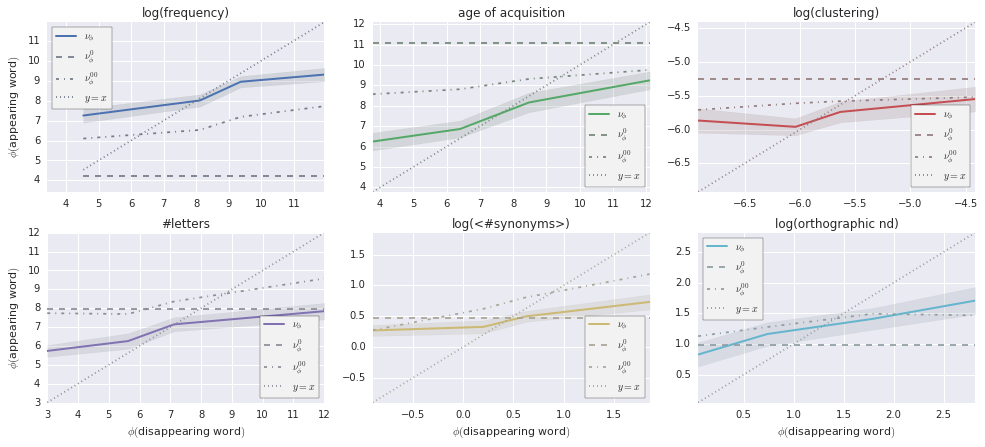

In [17]:
plot_grid(variations, PAPER_FEATURES,
          'paper-variations-quantilebins_global', plot_variation,
          r'$\phi($disappearing word$)$', r'$\phi($appearing word$)$',
          plot_kws={'quantiles': True})

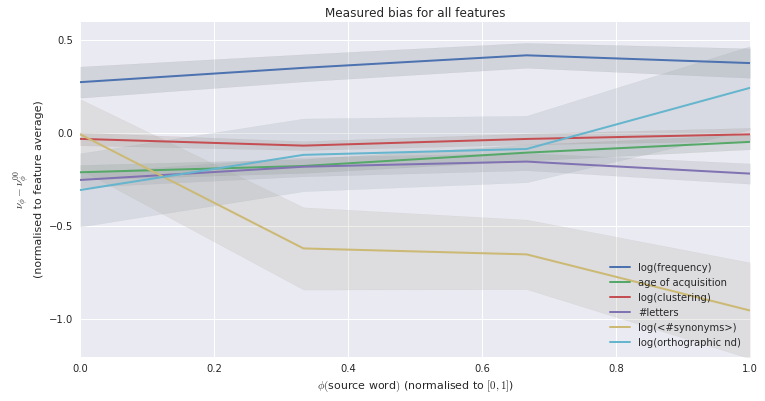

In [18]:
plot_overlay(variations, PAPER_FEATURES,
             'paper-variations_bias-quantilebins_global',
             'deep', plot_bias, 'Measured bias for all features',
             r'$\phi($source word$)$ (normalised to $[0, 1]$)',
             r'$\nu_{\phi} - \nu_{\phi}^{00}$'
                 '\n(normalised to feature average)',
             plot_kws={'quantiles': True})\
    .set_ylim(-1.2, .6);

### 2.2 Sentence-relative feature values

#### 2.2.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | ns. |

--------------
phonemes_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | *** |
H_00 | **  | ns. | ns. | *   |

---------------
syllables_count
---------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | **  | *** | *   | *** |
H_00 | ns. | *   | ns. | *   |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | ns. |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *   | *** | ns. |
H_00 | ns. | *** | *** | *** |

-----------
betweenness
-----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | ns. | *** | *** |
H_00 | ns. | ns. | *** | *** |

----------
clustering

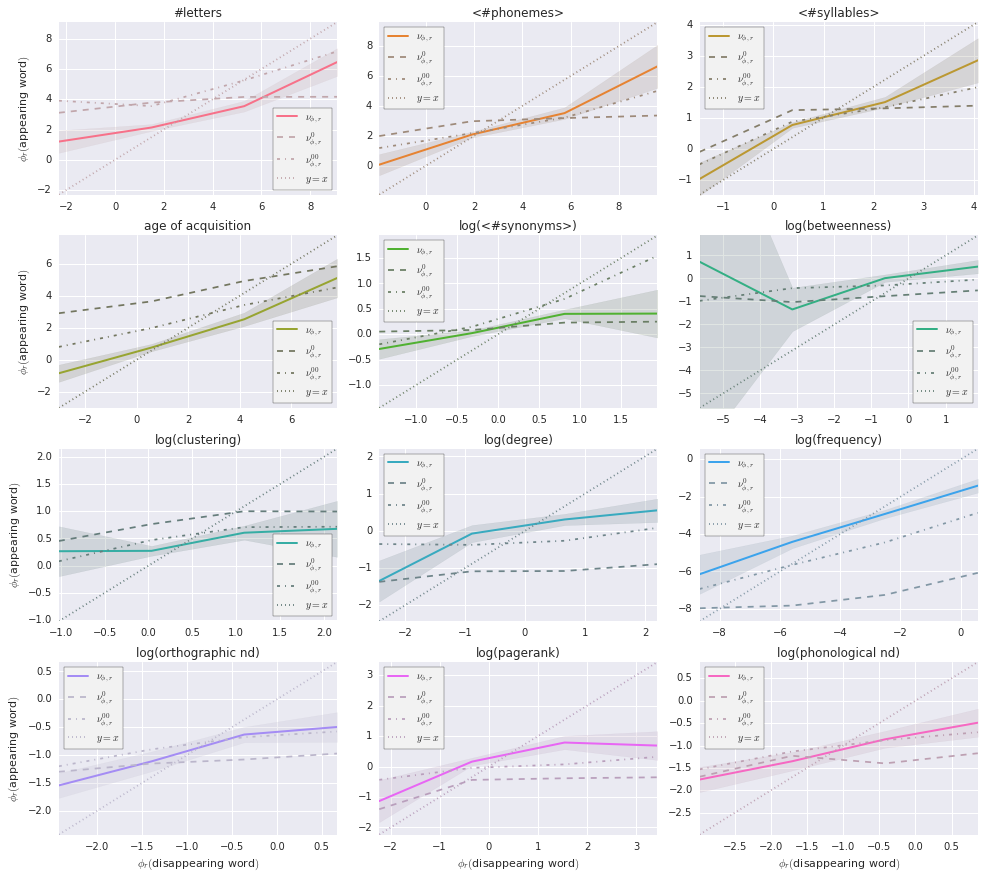

In [19]:
plot_grid(variations, ordered_features,
          'all-variations-fixedbins_sentencerel', plot_variation,
          r'$\phi_r($disappearing word$)$',
          r'$\phi_r($appearing word$)$',
          plot_kws={'relative': True})

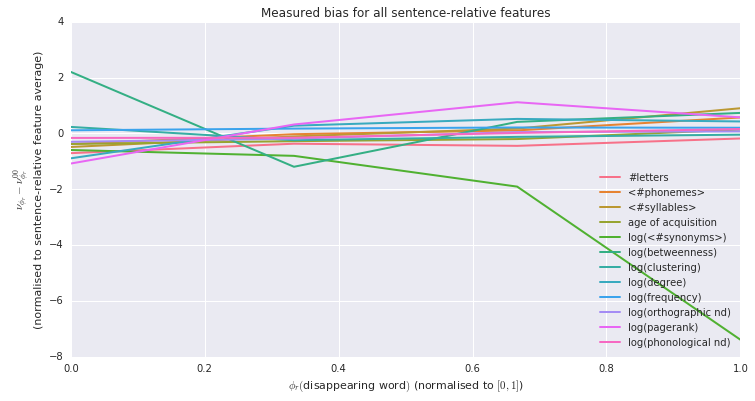

In [20]:
plot_overlay(variations, ordered_features,
             'all-variations_bias-fixedbins_sentencerel',
             'husl', plot_bias,
             'Measured bias for all sentence-relative features',
             r'$\phi_r($disappearing word$)$'
                 r' (normalised to $[0, 1]$)',
             r'$\nu_{\phi_r} - \nu_{\phi_r}^{00}$'
                 '\n(normalised to sentence-relative feature average)',
             plot_kws={'ci': False, 'relative': True});


---------
frequency
---------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | **  | *** | *** | *** |
H_00 | ns. | *** | *** | *** |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | ns. |

----------
clustering
----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | *** | *** | ns. |
H_00 | ns. | *** | ns. | ns. |

-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | ns. |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *   | *** | ns. |
H_00 | ns. | *** | *** | *** |

--------------------
orthographic_density
--------------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *   | ns. | *** | *** |
H_00 | **  | *   | ns. | ns. |


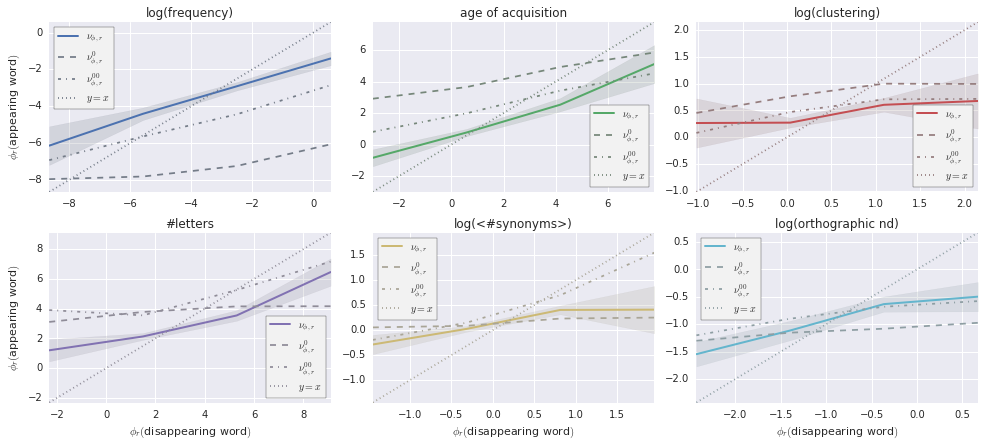

In [21]:
plot_grid(variations, PAPER_FEATURES,
          'paper-variations-fixedbins_sentencerel', plot_variation,
          r'$\phi_r($disappearing word$)$',
          r'$\phi_r($appearing word$)$',
          plot_kws={'relative': True})

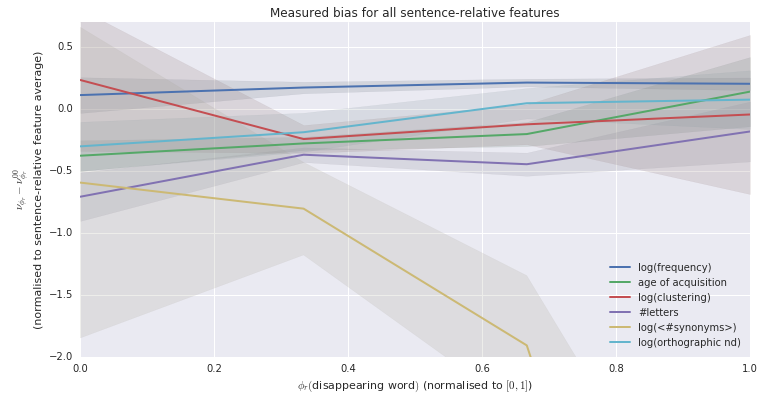

In [22]:
plot_overlay(variations, PAPER_FEATURES,
             'paper-variations_bias-fixedbins_sentencerel',
             'deep', plot_bias,
             'Measured bias for all sentence-relative features',
             r'$\phi_r($disappearing word$)$'
                 r' (normalised to $[0, 1]$)',
             r'$\nu_{\phi_r} - \nu_{\phi_r}^{00}$'
                 '\n(normalised to sentence-relative feature average)',
             plot_kws={'relative': True})\
    .set_ylim(-2, .7);

#### 2.2.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | *** |

--------------
phonemes_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | **  |
H_00 | ns. | ns. | ns. | *   |

---------------
syllables_count
---------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | ns. | *** |
H_00 | **  | ns. | *   | *   |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *   |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | ns. | ns. | *** |
H_00 | **  | ns. | *** | *** |

-----------
betweenness
-----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | ns. | *   | *** | *   |

----------
clustering

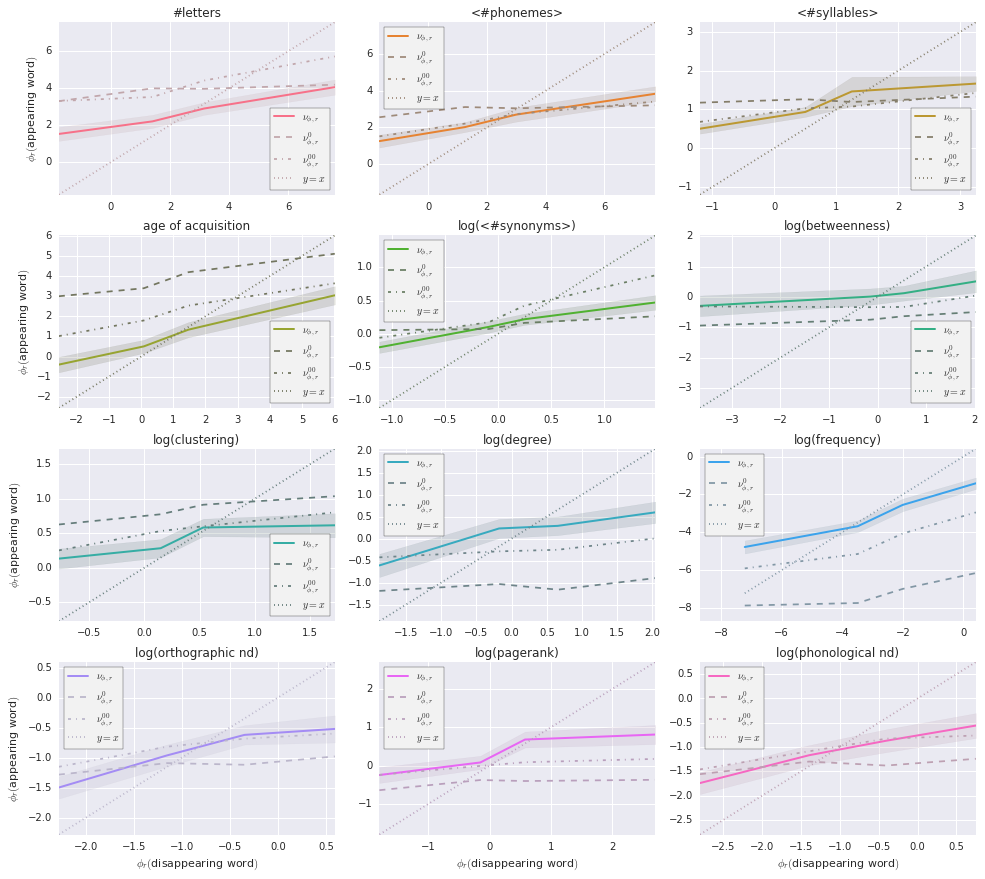

In [23]:
plot_grid(variations, ordered_features,
          'all-variations-quantilebins_sentencerel', plot_variation,
          r'$\phi_r($disappearing word$)$',
          r'$\phi_r($appearing word$)$',
          plot_kws={'relative': True, 'quantiles': True})

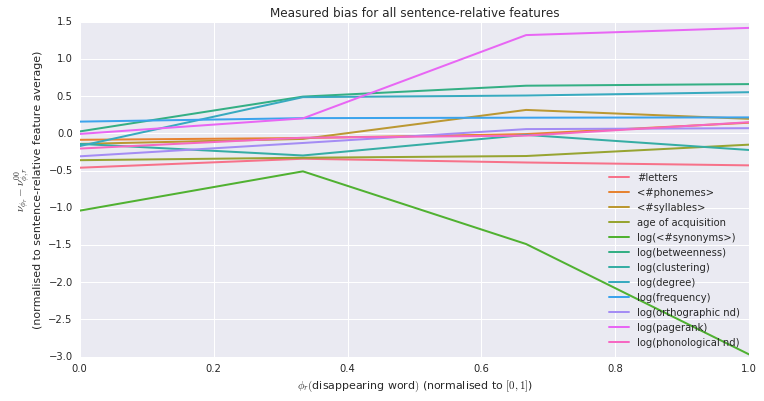

In [24]:
plot_overlay(variations, ordered_features,
             'all-variations_bias-quantilebins_sentencerel',
             'husl', plot_bias,
             'Measured bias for all sentence-relative features',
             r'$\phi_r($disappearing word$)$'
                 r' (normalised to $[0, 1]$)',
             r'$\nu_{\phi_r} - \nu_{\phi,r}^{00}$'
                 '\n(normalised to sentence-relative feature average)',
             plot_kws={'ci': False, 'relative': True, 'quantiles': True});


---------
frequency
---------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *** |

---
aoa
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | *** | *** | *** | *   |

----------
clustering
----------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | *** |
H_00 | ns. | *** | ns. | *   |

-------------
letters_count
-------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | *** |

--------------
synonyms_count
--------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | ns. | ns. | *** |
H_00 | **  | ns. | *** | *** |

--------------------
orthographic_density
--------------------
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *   | ns. | *** | *** |
H_00 | *** | ns. | ns. | ns. |


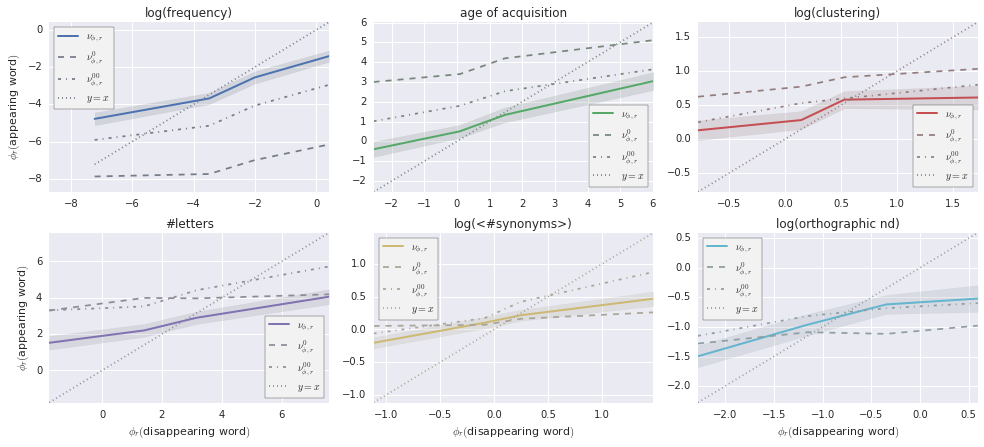

In [25]:
plot_grid(variations, PAPER_FEATURES,
          'paper-variations-quantilebins_sentencerel', plot_variation,
          r'$\phi_r($disappearing word$)$',
          r'$\phi_r($appearing word$)$',
          plot_kws={'relative': True, 'quantiles': True})

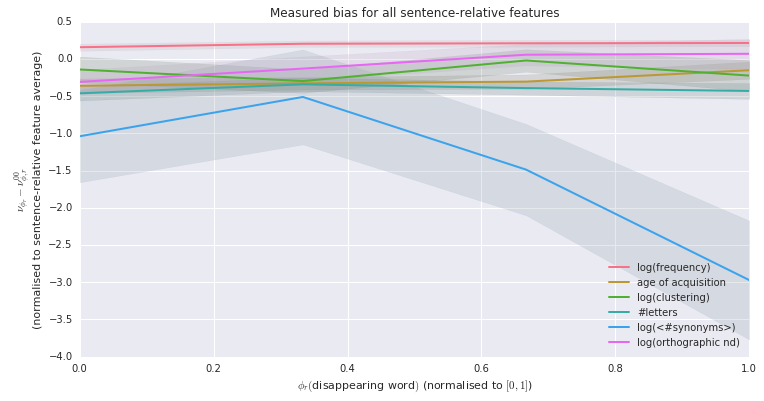

In [26]:
plot_overlay(variations, PAPER_FEATURES,
             'paper-variations_bias-quantilebins_sentencerel',
             'husl', plot_bias,
             'Measured bias for all sentence-relative features',
             r'$\phi_r($disappearing word$)$'
                 r' (normalised to $[0, 1]$)',
             r'$\nu_{\phi_r} - \nu_{\phi,r}^{00}$'
                 '\n(normalised to sentence-relative feature average)',
             plot_kws={'relative': True, 'quantiles': True});

## 3 Streamplots

We'd like to see what happens between absolute and relative feature values, i.e. how do their effects interact. Especially, we want to know who wins between cognitive bias, attraction to sentence average, or attraction to global feature average.

To do this we plot the general direction (arrows) and strength (color) of where destination words are given a particular absolute/relative source feature couple. I.e., for a given absolute feature value and relative feature value, if this word were to be substituted, where would it go in this (absolute, relative) space?

The interesting thing in these plots is the attraction front, where all arrows point to and join. We're interested in:
* its slope
* its shape (e.g. several slope regimes?)
* its position w.r.t. $\nu_{\phi}^0$ and $y = 0$ (which is $\left< \phi(sentence) \right>$)

First, here's our plotting function. (Note we set the arrow size to something that turns out to be huge here, but gives normal sizes in the figures saves. There must be some dpi scaling problem with the arrows.)

In [27]:
def plot_stream(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    source = data['source']
    source_rel = data['source_rel']
    dest = data['destination']
    dest_rel = data['destination_rel']
    h0 = data['h0']
    
    # Compute binning.
    bin_count = 4
    x_bins, x_margins = pd.cut(source, bin_count,
                               right=False, labels=False, retbins=True)
    x_middles = (x_margins[:-1] + x_margins[1:]) / 2
    y_bins, y_margins = pd.cut(source_rel, bin_count,
                               right=False, labels=False, retbins=True)
    y_middles = (y_margins[:-1] + y_margins[1:]) / 2
    
    # Compute bin values.
    h0s = np.ones(bin_count) * h0.iloc[0]
    u_values = np.zeros((bin_count, bin_count))
    v_values = np.zeros((bin_count, bin_count))
    strength = np.zeros((bin_count, bin_count))
    for x in range(bin_count):
        for y in range(bin_count):
            u_values[y, x] = (
                dest[(x_bins == x) & (y_bins == y)] -
                source[(x_bins == x) & (y_bins == y)]
            ).mean()
            v_values[y, x] = (
                dest_rel[(x_bins == x) & (y_bins == y)] -
                source_rel[(x_bins == x) & (y_bins == y)]
            ).mean()
            strength[y, x] = np.sqrt(
                (dest[(x_bins == x) & (y_bins == y)] - 
                 source[(x_bins == x) & (y_bins == y)]) ** 2 +
                (dest_rel[(x_bins == x) & (y_bins == y)] - 
                 source_rel[(x_bins == x) & (y_bins == y)]) ** 2
            ).mean()
    
    # Plot.
    plt.streamplot(x_middles, y_middles, u_values, v_values,
                   arrowsize=4, color=strength, cmap=plt.cm.viridis)
    plt.plot(x_middles, np.zeros(bin_count), linestyle='-',
             color=sb.desaturate(color, 0.2), 
             label=r'$\left< \phi(sentence) \right>$')
    plt.plot(h0s, y_middles, linestyle='--',
             color=sb.desaturate(color, 0.2), label=r'$\nu_{\phi}^0$')
    plt.xlim(x_middles[0], x_middles[-1])
    plt.ylim(y_middles[0], y_middles[-1])

Here are the plots for all features

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


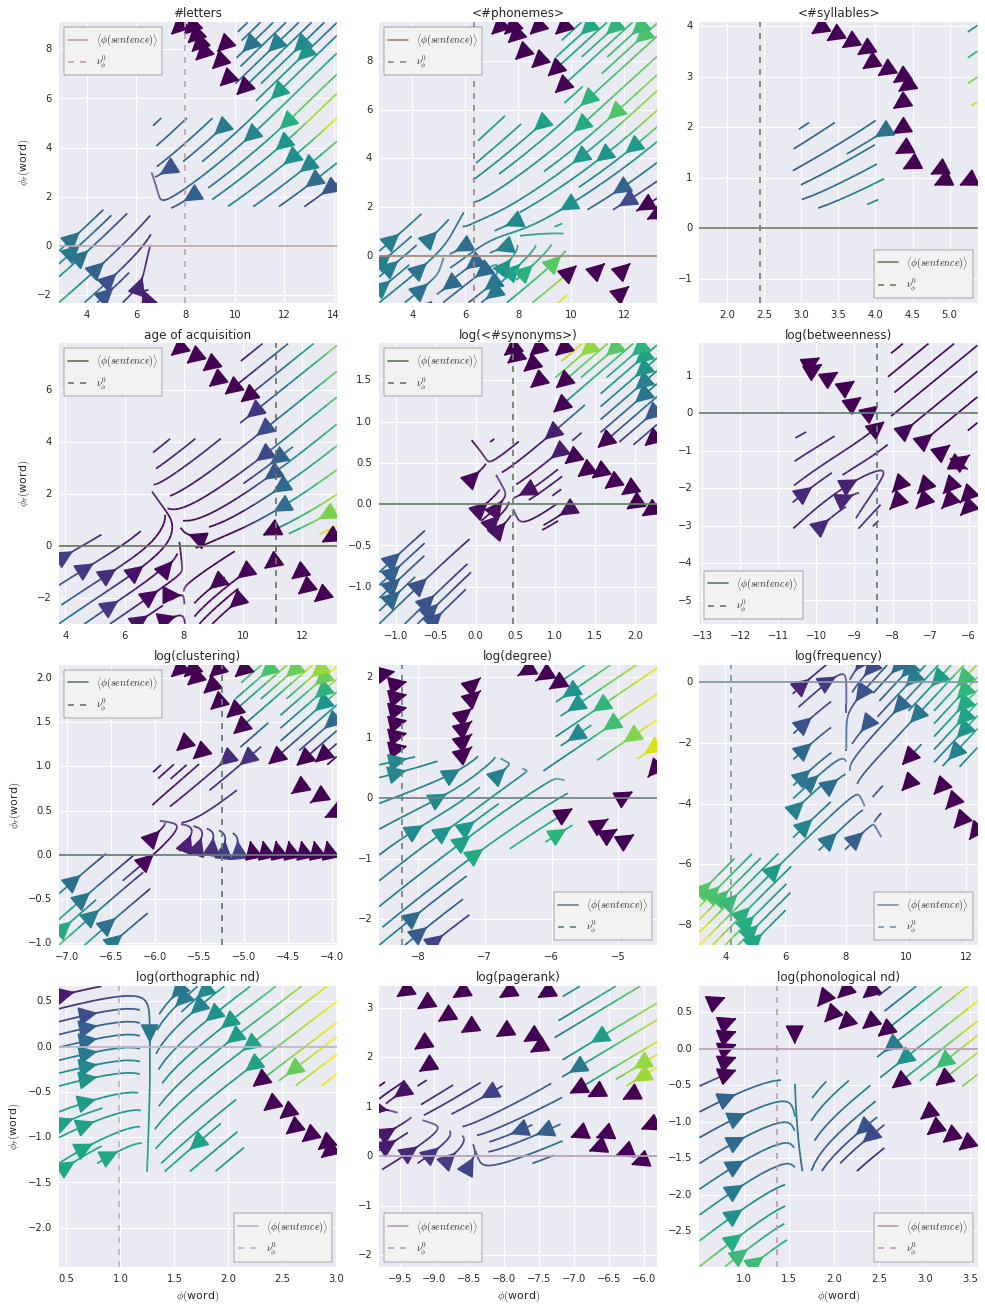

In [28]:
g = sb.FacetGrid(data=variations,
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1, size=4.5,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_stream)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($word$)$')
g.set_ylabels(r'$\phi_r($word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='best')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_streams'),
                  bbox_inches='tight', dpi=300)

And here are the plots for the features we expose in the paper

/home/sl/.virtualenvs/brainscopypaste/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


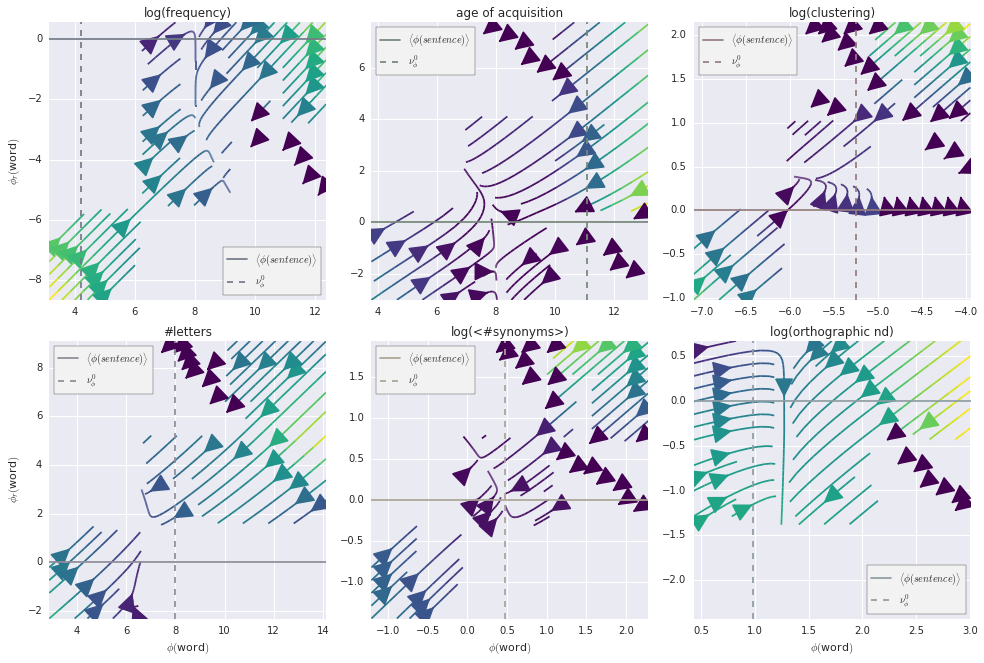

In [29]:
g = sb.FacetGrid(data=variations[variations['feature']
                                 .map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1, size=4.5,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_stream)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($word$)$')
g.set_ylabels(r'$\phi_r($word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='best')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_streams'),
                  bbox_inches='tight', dpi=300)

## 4 PCA'd feature variations

Compute PCA on feature *variations* (note: on variations, not on features directly), and show the evolution of the first three components upon substitution.

**CAVEAT**: the PCA is computed on variations where all features are defined. This greatly reduces the number of words included (and also the number of substitutions -- see below for real values, but you should know it's drastic). This also has an effect on the computation of $\mathcal{H}_0$ and $\mathcal{H}_{00}$, which are computed using words for which all features are defined. This, again, hugely reduces the number of words taken into account, changing the values under the null hypotheses.

### 4.1 On all the features

Compute the actual PCA

In [30]:
# Compute the PCA.
pcafeatures = tuple(sorted(Substitution.__features__))
pcavariations = variations.pivot(index='cluster_id',
                                 columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:"
      .format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=pcafeatures,
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 11 components.

Those explain the following variance:
[ 0.54601438  0.15938617  0.08145657  0.07174038  0.03516331  0.02791302
  0.02146007  0.01836326  0.01624824  0.01029141  0.00737022]

We're plotting variation for the first 3 components:


,aoa,betweenness,clustering,degree,frequency,letters_count,orthographic_density,pagerank,phonemes_count,phonological_density,syllables_count,synonyms_count
Component-0,-0.492463,0.294978,-0.101583,0.244914,0.251340,-0.418117,0.213284,0.268325,-0.377521,0.280270,-0.153406,0.008792
Component-1,-0.339265,0.351267,-0.093073,0.273678,0.231802,0.420829,-0.161448,0.310660,0.481343,-0.249358,0.173202,-0.025981
Component-2,-0.652011,-0.154437,0.035430,-0.073182,-0.725758,0.046095,0.008336,-0.081155,0.022628,-0.078460,0.014312,0.045194


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [31]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(N_COMPONENTS):
            source, destination = substitution\
                .components(component, pca, pcafeatures)
            data.append({
                'cluster_id': substitution.source.cluster.sid,
                'destination_id': substitution.destination.sid,
                'occurrence': substitution.occurrence,
                'position': substitution.position,
                'source_id': substitution.source.sid,
                'component': component,
                'source': source,
                'destination': destination,
                'h0': substitution.component_average(component, pca,
                                                     pcafeatures),
                'h0n': substitution.component_average(component, pca,
                                                      pcafeatures,
                                                      source_synonyms=True)
            })

original_component_variations = pd.DataFrame(data)
del data

100% (6318 of 6318) |######################| Elapsed Time: 0:01:45 Time: 0:01:45


Compute cluster averages (so as not to overestimate confidence intervals).

In [32]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'position', 'component'],
             as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components (**see the caveat section below**)


---
0.0
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | ns. | *** | *** |
H_00 | *   | ns. | *   | **  |

---
1.0
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | *** | *** | **  |
H_00 | ns. | *** | *** | *   |

---
2.0
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | *** | *** | ns. |
H_00 | ns. | *** | **  | ns. |


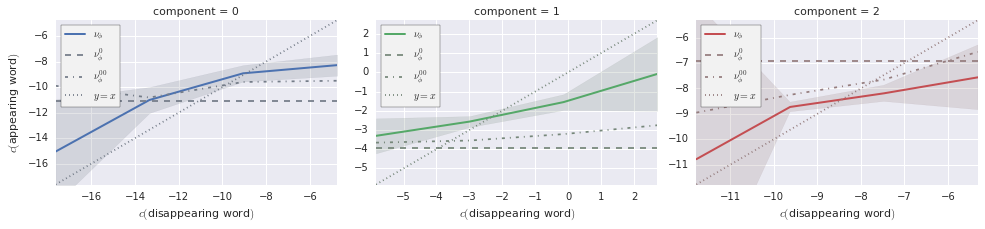

In [33]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation, feature_field='component')
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-pca_variations-absolute'),
                  bbox_inches='tight', dpi=300)

### 4.2 On a subset of relevant features

In [34]:
relevant_features = ['frequency', 'aoa', 'letters_count']

Compute the actual PCA

In [35]:
# Compute the PCA.
pcafeatures = tuple(sorted(relevant_features))
pcavariations = variations[variations['feature']
                           .map(lambda f: f in pcafeatures)]\
    .pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

pd.DataFrame(pca.components_,
             columns=pcafeatures,
             index=['Component-{}'.format(i)
                    for i in range(pca.n_components_)])

MLE estimates there are 2 components.

Those explain the following variance:
[ 0.64694229  0.21386368]



,aoa,frequency,letters_count
Component-0,-0.732385,0.381288,-0.564120
Component-1,0.326151,-0.530816,-0.782214


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [36]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(pca.n_components_):
            source, destination = substitution.components(component, pca,
                                                          pcafeatures)
            data.append({
                'cluster_id': substitution.source.cluster.sid,
                'destination_id': substitution.destination.sid,
                'occurrence': substitution.occurrence,
                'position': substitution.position,
                'source_id': substitution.source.sid,
                'component': component,
                'source': source,
                'destination': destination,
                'h0': substitution.component_average(component, pca,
                                                     pcafeatures),
                'h0n': substitution.component_average(component, pca,
                                                      pcafeatures,
                                                      source_synonyms=True)
            })

original_component_variations = pd.DataFrame(data)
del data

100% (6318 of 6318) |######################| Elapsed Time: 0:00:50 Time: 0:00:50


Compute cluster averages (so as not to overestimate confidence intervals).

In [37]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'position', 'component'],
             as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components


---
0.0
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | ns. | *** | *** | *** |
H_00 | ns. | ns. | *** | *** |

---
1.0
---
Bin  |   1 |   2 |   3 |   4 |
------------------------------
H_0  | *** | *** | *** | ns. |
H_00 | *** | *** | *** | ns. |


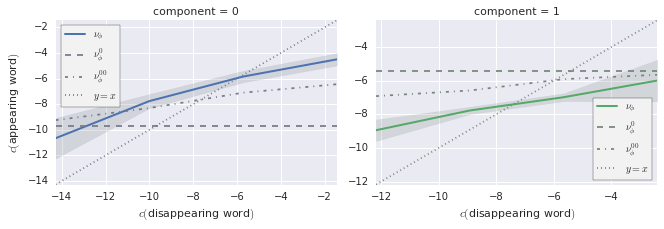

In [38]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation, feature_field='component')
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='best')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-pca_variations-absolute'),
                  bbox_inches='tight', dpi=300)

### 4.3 CAVEAT: reduction of the numbers of words and substitutions

As explained above, this PCA analysis can only use words for which *all* the features are defined (in this case, the features listed in `relevant_features`). So note the following:

In [39]:
for feature in relevant_features:
    print("Feature '{}' is based on {} words."
          .format(feature, len(Substitution
                               ._transformed_feature(feature)())))

# Compute the number of words that have all PAPER_FEATURES defined.
words = set()
for tfeature in [Substitution._transformed_feature(feature)
                 for feature in relevant_features]:
    words.update(tfeature())

data = dict((feature, []) for feature in relevant_features)
words_list = []
for word in words:
    words_list.append(word)
    for feature in relevant_features:
        data[feature].append(Substitution
                             ._transformed_feature(feature)(word))
wordsdf = pd.DataFrame(data)
wordsdf['words'] = words_list
del words_list, data

print()
print("Among all the set of words used by these features, "
      "only {} are used."
      .format(len(wordsdf.dropna())))

print()
print("Similarly, we mined {} (cluster-unique) substitutions, "
      "but the PCA is in fact"
      " computed on {} of them (those where all features are defined)."
      .format(len(set(variations['cluster_id'])), len(pcavariations)))

Feature 'frequency' is based on 33450 words.
Feature 'aoa' is based on 30102 words.
Feature 'letters_count' is based on 42786 words.

Among all the set of words used by these features, only 14450 are used.

Similarly, we mined 698 (cluster-unique) substitutions, but the PCA is in fact computed on 525 of them (those where all features are defined).


The way $\mathcal{H}_0$ and $\mathcal{H}_{00}$ are computed makes them also affected by this.

## 5 Interactions between features (by Anova)

Some useful variables first.

In [40]:
cuts = [('fixed bins', pd.cut)]#, ('quantiles', pd.qcut)]
rels = [('global', ''), ('sentence-relative', '_rel')]

def star_level(p):
    if p < .001:
        return '***'
    elif p < .01:
        return ' **'
    elif p < .05:
        return '  *'
    else:
        return 'ns.'

Now for each feature, assess if it has an interaction with the other features' **destination value**. We look at this for all pairs of features, with all pairs of global/sentence-relative value and types of binning (fixed width/quantiles). So it's a lot of answers.

Three stars means $p < .001$, two $p < .01$, one $p < .05$, and `ns.` means non-significative.

In [41]:
for feature1 in PAPER_FEATURES:
    print('-' * len(feature1))
    print(feature1)
    print('-' * len(feature1))

    for feature2 in PAPER_FEATURES:
        print()
        print('-> {}'.format(feature2))
        for (cut_label, cut), (rel1_label, rel1) in product(cuts, rels):
            for (rel2_label, rel2) in rels:
                source = variations.pivot(
                    index='cluster_id', columns='feature',
                    values='source' + rel1)[feature1]
                destination = variations.pivot(
                    index='cluster_id', columns='feature',
                    values='destination' + rel2)[feature2]

                # Compute binning.
                for bin_count in range(BIN_COUNT, 0, -1):
                    try:
                        source_bins = cut(source, bin_count, labels=False)
                        break
                    except ValueError:
                        pass

                _, p = stats.f_oneway(*[destination[source_bins == i]
                                        .dropna()
                                        for i in range(bin_count)])
                print('  {} {} -> {}'
                      .format(star_level(p), rel1_label, rel2_label))
    print()

---------
frequency
---------

-> frequency
  *** global -> global
  *** global -> sentence-relative
  *** sentence-relative -> global
  *** sentence-relative -> sentence-relative

-> aoa
  *** global -> global
  *** global -> sentence-relative
  *** sentence-relative -> global
  *** sentence-relative -> sentence-relative

-> clustering
    * global -> global
  ns. global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

-> letters_count
  *** global -> global
  *** global -> sentence-relative
  ns. sentence-relative -> global
  *** sentence-relative -> sentence-relative

-> synonyms_count
  ns. global -> global
  ns. global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

-> orthographic_density
  *** global -> global
  *** global -> sentence-relative
  ns. sentence-relative -> global
  *** sentence-relative -> sentence-relative

---
aoa
---

-> frequency
  *** global -> global
    *

Now for each feature, look at its interaction with the other features' **variation (i.e. destination - source)**. Same drill, same combinations.

In [42]:
for feature1 in PAPER_FEATURES:
    print('-' * len(feature1))
    print(feature1)
    print('-' * len(feature1))

    for feature2 in PAPER_FEATURES:
        print()
        print('-> {}'.format(feature2))
        for (cut_label, cut), (rel1_label, rel1) in product(cuts, rels):
            for (rel2_label, rel2) in rels:
                source = variations.pivot(
                    index='cluster_id', columns='feature',
                    values='source' + rel1)[feature1]
                destination = variations.pivot(
                    index='cluster_id', columns='feature',
                    values='destination' + rel2)[feature2]\
                    - variations.pivot(
                    index='cluster_id', columns='feature',
                    values='source' + rel2)[feature2]

                # Compute binning.
                for bin_count in range(BIN_COUNT, 0, -1):
                    try:
                        source_bins = cut(source, bin_count, labels=False)
                        break
                    except ValueError:
                        pass

                _, p = stats.f_oneway(*[destination[source_bins == i]
                                        .dropna()
                                        for i in range(bin_count)])
                print('  {} {} -> {}'
                      .format(star_level(p), rel1_label, rel2_label))
    print()

---------
frequency
---------

-> frequency
  *** global -> global
  *** global -> sentence-relative
  *** sentence-relative -> global
  *** sentence-relative -> sentence-relative

-> aoa
  *** global -> global
  *** global -> sentence-relative
  *** sentence-relative -> global
  *** sentence-relative -> sentence-relative

-> clustering
  ns. global -> global
  ns. global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

-> letters_count
    * global -> global
    * global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

-> synonyms_count
   ** global -> global
   ** global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

-> orthographic_density
  ns. global -> global
  ns. global -> sentence-relative
  ns. sentence-relative -> global
  ns. sentence-relative -> sentence-relative

---
aoa
---

-> frequency
  *** global -> global
  ***

Ok, so this can go on for a long time, and I'm not going to look at interactions with this lens (meaning at interaction of couples of features with another feature's destination values).

## 6 Regression

In [43]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [44]:
def prettify_index(index):
    return pd.Index(name=index.name,
                    data=index.map(lambda f: Substitution
                                   ._transformed_feature(f).__doc__))

First try regressing the global feature variations based on the global source features, then the average of global feature variations.

Regressing destination global values with 273 measures
R^2 = 0.32880088378014444

Details for FREQUENCY
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     18.07
Date:                Fri, 29 Jul 2016   Prob (F-statistic):           1.40e-17
Time:                        16:13:44   Log-Likelihood:                 182.98
No. Observations:                 273   AIC:                            -352.0
Df Residuals:                     266   BIC:                            -326.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

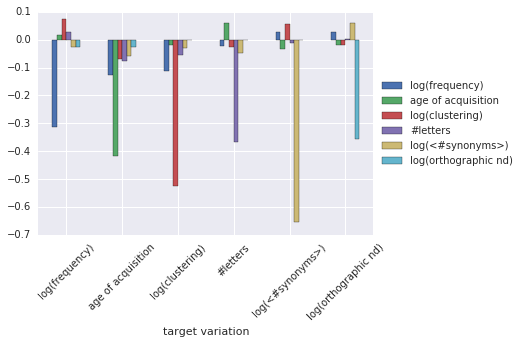

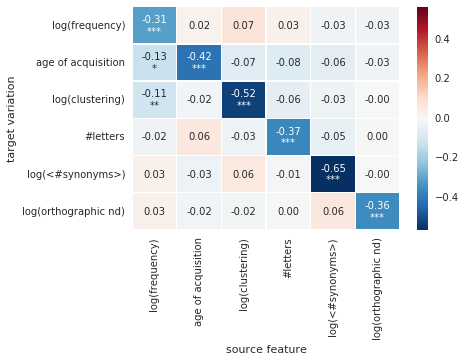

In [45]:
# Get source and destination values.
source = pd.pivot_table(
    variations,
    values='source',
    index=['cluster_id'],
    columns=['feature']
)[PAPER_FEATURES].dropna()
destination = pd.pivot_table(
    variations,
    values='destination',
    index=['cluster_id'],
    columns=['feature']
).loc[source.index][PAPER_FEATURES].dropna()
source = source.loc[destination.index]
nsource = ((source.values - source.values.min(0))
           / (source.values.max(0) - source.values.min(0)))
target = destination.values - source.values
target = (target - target.min(0)) / (target.max(0) - target.min(0))

# Regress.
linreg = linear_model.LinearRegression()
linreg.fit(nsource, target)

# And print the score.
print('Regressing destination global values with {} measures'
      .format(len(source)))
print('R^2 = {}'.format(linreg.score(nsource, target)))
coeffs = pd.DataFrame(data=linreg.coef_,
                      index=prettify_index(destination.columns
                                           .rename('target variation')),
                      columns=prettify_index(source.columns
                                             .rename('source feature')))
#coeffs['intercept'] = linreg.intercept_

# Plot the coefficients.
ax = coeffs.plot(kind='bar', rot=45)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.figure()
axh = sb.heatmap(coeffs, annot=True, fmt=".2f", linewidths=.5, robust=True)

# Print the OLS details, and augment the heatmap texts with significance
# stars.
def stars_addendum(p):
    if p <= .001:
        return '\n***'
    elif p <= .01:
        return '\n**'
    elif p <= .05:
        return '\n*'
    else:
        return ''

print()
texts = np.array(axh.texts).reshape((len(PAPER_FEATURES),
                                     len(PAPER_FEATURES)))[::-1]
for i, feature in enumerate(PAPER_FEATURES):
    sm_results = sm.OLS(target[:, i], sm.add_constant(nsource)).fit()
    for j, p in enumerate(sm_results.pvalues[1:]):
        texts[i, j].set_text(texts[i, j].get_text()
                             + stars_addendum(p))
    print('=' * 78)
    print('Details for {}'.format(feature.upper()))
    print(sm_results.summary())

if SAVE_FIGURES:
    ax.figure.savefig(settings.FIGURE
                      .format('paper-variations_regression-'
                              'globals_to_globalsvariation'),
                      bbox_inches='tight', dpi=300)
    axh.figure.savefig(settings.FIGURE
                       .format('paper-variations_regression-'
                               'globals_to_globalsvariation-heatmap'),
                       bbox_inches='tight', dpi=300)

Regressing destination global values with 273 measures
R^2 = 0.36079572187138587

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     25.02
Date:                Fri, 29 Jul 2016   Prob (F-statistic):           1.71e-23
Time:                        16:13:46   Log-Likelihood:                 488.32
No. Observations:                 273   AIC:                            -962.6
Df Residuals:                     266   BIC:                            -937.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

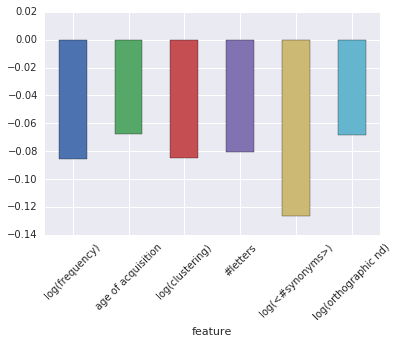

In [46]:
# Get source and destination values.
source = pd.pivot_table(
    variations,
    values='source',
    index=['cluster_id'],
    columns=['feature']
)[PAPER_FEATURES].dropna()
destination = pd.pivot_table(
    variations,
    values='destination',
    index=['cluster_id'],
    columns=['feature']
).loc[source.index][PAPER_FEATURES].dropna()
source = source.loc[destination.index]
nsource = ((source.values - source.values.min(0))
           / (source.values.max(0) - source.values.min(0)))
target = destination.values - source.values
target = ((target - target.min(0)) / (target.max(0) - target.min(0))).mean(1)

# Regress.
linreg = linear_model.LinearRegression()
linreg.fit(nsource, target)

# And print the score and coefficients.
print('Regressing destination global values with {} measures'
      .format(len(source)))
print('R^2 = {}'.format(linreg.score(nsource, target)))
print()
print(sm.OLS(target, sm.add_constant(nsource)).fit().summary())
coeffs = pd.Series(data=linreg.coef_,
                   index=prettify_index(source.columns))
#coeffs['intercept'] = linreg.intercept_
ax = coeffs.plot(kind='bar', color=sb.color_palette(n_colors=6), rot=45)
if SAVE_FIGURES:
    ax.figure.savefig(settings.FIGURE
                      .format('paper-variations_regression-'
                              'globals_to_meanvariation'),
                      bbox_inches='tight', dpi=300)

The following details a humongous list of possible regressions, which we won't use.

In [47]:
rels = {False: ('global', ''),
        True: ('rel', '_rel')}

def regress(data, features, target,
            source_rel=False, dest_rel=False, interactions=False):
    if source_rel not in [True, False, 'both']:
        raise ValueError
    if not isinstance(dest_rel, bool):
        raise ValueError
    # Process source/destination relativeness arguments.
    if isinstance(source_rel, bool):
        source_rel = [source_rel]
    else:
        source_rel = [False, True]
    dest_rel_name, dest_rel = rels[dest_rel]
    
    features = tuple(sorted(features))
    feature_tuples = [('source' + rels[rel][1], feature)
                      for rel in source_rel
                      for feature in features]
    feature_names = [rels[rel][0] + '_' + feature
                     for rel in source_rel
                     for feature in features]
    
    # Get source and destination values.
    source = pd.pivot_table(
        data,
        values=['source' + rels[rel][1] for rel in source_rel],
        index=['cluster_id'],
        columns=['feature']
    )[feature_tuples].dropna()
    destination = variations[variations.feature == target]\
        .pivot(index='cluster_id', columns='feature',
               values='destination' + dest_rel)\
        .loc[source.index][target].dropna()
    source = source.loc[destination.index].values
    destination = destination.values

    # If asked to, get polynomial features.
    if interactions:
        poly = PolynomialFeatures(degree=2, interaction_only=True)
        source = poly.fit_transform(source)
        regress_features = [' * '.join([feature_names[j]
                                        for j, p in enumerate(powers)
                                        if p > 0]) or 'intercept'
                            for powers in poly.powers_]
    else:
        regress_features = feature_names

    # Regress.
    linreg = linear_model.LinearRegression(fit_intercept=not interactions)
    linreg.fit(source, destination)

    # And print the score and coefficients.
    print('Regressing {} with {} measures, {} interactions'
          .format(dest_rel_name + ' ' + target, len(source),
                  'with' if interactions else 'no'))
    print('           ' + '^' * len(dest_rel_name + ' ' + target))
    print('R^2 = {}'
          .format(linreg.score(source, destination)))
    print()
    coeffs = pd.Series(index=regress_features, data=linreg.coef_)
    if not interactions:
        coeffs = pd.Series(index=['intercept'], data=[linreg.intercept_])\
            .append(coeffs)
    with pd.option_context('display.max_rows', 999):
        print(coeffs)

In [48]:
for target in PAPER_FEATURES:
    print('-' * 70)
    for source_rel, dest_rel in product([False, True, 'both'],
                                        [False, True]):
        regress(variations, PAPER_FEATURES, target, source_rel=source_rel,
                dest_rel=dest_rel)
        print()
        regress(variations, PAPER_FEATURES, target, source_rel=source_rel,
                dest_rel=dest_rel, interactions=True)
        print()

----------------------------------------------------------------------
Regressing global frequency with 391 measures, no interactions
           ^^^^^^^^^^^^^^^^
R^2 = 0.09853263729254713

intercept                      5.681805
global_aoa                     0.098454
global_clustering              0.169474
global_frequency               0.419654
global_letters_count          -0.035324
global_orthographic_density   -0.105466
global_synonyms_count         -0.173456
dtype: float64

Regressing global frequency with 391 measures, with interactions
           ^^^^^^^^^^^^^^^^
R^2 = 0.12882465936510978

intercept                                              8.718810
global_aoa                                            -0.606622
global_clustering                                      1.369041
global_frequency                                       0.822327
global_letters_count                                   0.094275
global_orthographic_density                            1.383686
global_syno